In [1]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)


import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn import linear_model
from sklearn.linear_model import Lasso, Ridge




In [3]:
# 2. Carreguem dades
df = pd.read_pickle("data/datos_preprocesados.pkl")
df = df.iloc[:, 3:]
df

,Investment,Inv_previa,Num_Inversio,Founded,es_sociedad_limitada,Ind Business Services & Software,Ind Healthtech,Ind Financing,Ind E-commerce & Marketplaces,Ind ICT & Mobile,...,Spin None Not a spinoff,Spin CERCA Centre,Spin University,Spin ICREA Centre,Spin Technological Centre,Spin Company Other Centre,Spin University - Hospital,Spin CSIC Centre,Spin I3PT,Spin TECNIO Centre
0,190.0,583.0,8,10.0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,95.0,488.0,7,10.0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,241.9,246.1,6,10.0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,132.0,114.1,5,10.0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,53.0,61.1,4,10.0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
618,0.0,0.0,2,6.0,1,1,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
619,0.0,0.0,1,6.0,1,1,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
620,0.0,0.0,1,5.0,1,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
621,0.0,0.0,1,2.0,1,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [4]:
x = df.drop("Investment", axis=1)
x.columns = x.columns.astype(str)   #No se perquè, però si no ho faig em dona error
y = df["Investment"]

In [5]:
print(x.shape)
print(y.shape)

(623, 117)
(623,)


Model de regressió normal i corrent

In [6]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=2)
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(train_X, train_y)
print(reg.score(train_X,train_y))
print(reg.score(test_X,test_y))

0.4822456814292835
-0.12093718826069111


Fatal, veiem que hi ha moltíssima variança en els paràmetres com a conseqüència d'un sobreajustament.
Podem utilitzar Lasso i Ridge regression per evitar-ho

Tenim molt poques dades, aleshores per cada lambda probarem centenars de possibles combinacions de de divisions de les dades en train i testing, aleshores al final farem la mitjana dels resultats i gaurdarem les dades a un dataframe, posteriorment escollirem el valor que fa tenir de mitjana uns resultats millors en el testing, de manera que trobarem el lambda que generalitza millor el model. Aleshores farem el model amb el 100% de les dades amb el lambda òptim

In [9]:
from sklearn import linear_model
from sklearn.linear_model import Lasso, Ridge

results = []
c = 0
for i in np.logspace(1, 2.7, num=40):
    m = []
    n = []
    for r in range(1,41):
        print(f"{round((c+(r-1)/40)/30*100,1)}%", end='\r', flush=True)
        train_X, test_X, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=r)
        lasso_reg = linear_model.Lasso(alpha=i, max_iter=100, tol=0.1)
        lasso_reg.fit(train_X, train_y)
        #print([i, ridge_reg.score(train_X, train_y), ridge_reg.score(test_X, test_y)])
        m.append(lasso_reg.score(train_X, train_y))
        n.append(lasso_reg.score(test_X, test_y))
    results.append([round(float(i), 3), round(float(np.mean(m)), 3), round(float(np.mean(n)), 3)])
    c = c+1

df_results_lasso = pd.DataFrame(results, columns=['alpha', 'train_score_mean', 'val_score_mean'])
print(df_results_lasso.loc[df_results_lasso['val_score_mean'].idxmax()])
df_results_lasso.to_pickle(path="data/lasso_NV.pkl")

#print(df_results_lasso)

alpha               166.155
train_score_mean      0.286
val_score_mean        0.162
Name: 28, dtype: float64


In [10]:
df_results_lasso = pd.read_pickle("data/lasso_NV.pkl")
alpha = float(df_results_lasso['val_score_mean'].max())
lasso_reg = linear_model.Lasso(alpha=alpha, max_iter=1000, tol=0.01)
lasso_reg.fit(x, y)
y_pred = lasso_reg.predict(x)
mse = mean_squared_error(y, y_pred)
print("R² (score):", lasso_reg.score(x, y))
print("MSE:", mse)

R² (score): 0.40110540093842684
MSE: 353.65393799113616


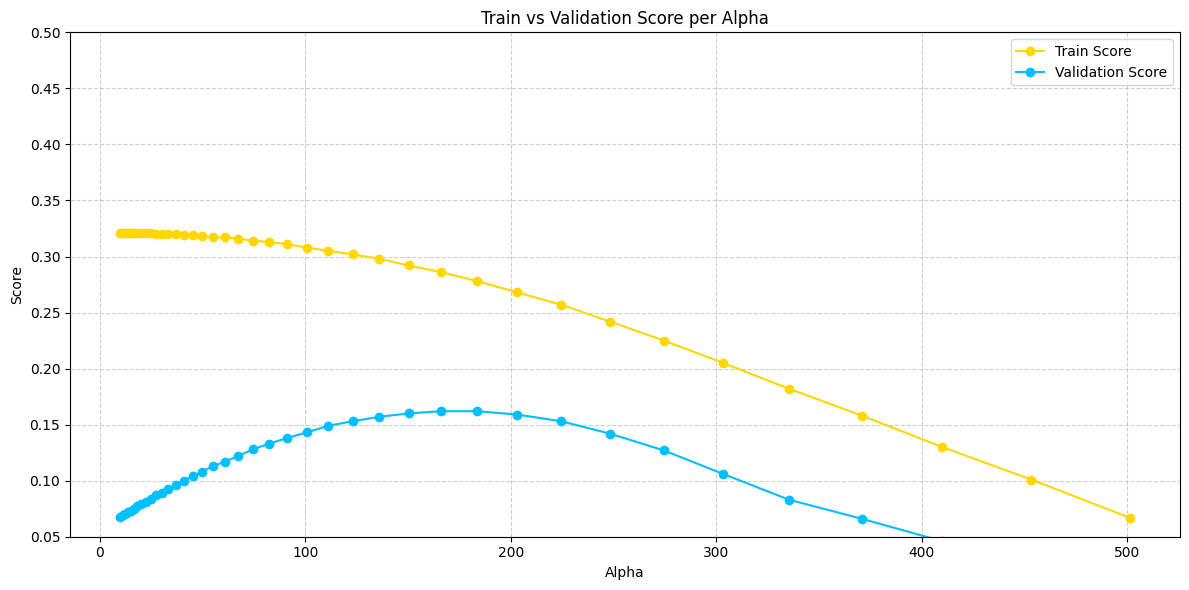

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Dades
alphas = df_results_lasso['alpha']
train_scores = df_results_lasso['train_score_mean']
val_scores = df_results_lasso['val_score_mean']

# Crear el gràfic de línies
plt.figure(figsize=(12, 6))
plt.plot(alphas, train_scores, marker='o', color='gold', label='Train Score')
plt.plot(alphas, val_scores, marker='o', color='deepskyblue', label='Validation Score')

# Etiquetes i títol
plt.xlabel('Alpha')
plt.ylabel('Score')
plt.title('Train vs Validation Score per Alpha')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.ylim(0.05, 0.5)

plt.show()


In [14]:
results = []
c=0
for i in np.logspace(-3, 3, num=20):
    m = []
    n = []
    c = c+1
    print(f"{(c-1)/20}%", end='\r', flush=True)
    for r in range(1,41):
        train_X, test_X, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=r)
        ridge_reg = linear_model.Ridge(alpha=i, max_iter=100, tol=0.1)
        ridge_reg.fit(train_X, train_y)
        #print([i, ridge_reg.score(train_X, train_y), ridge_reg.score(test_X, test_y)])
        m.append(ridge_reg.score(train_X, train_y))
        n.append(ridge_reg.score(test_X, test_y))
    results.append([round(float(i), 3), round(float(np.mean(m)), 3), round(float(np.mean(n)), 3)])

df_results_ridge = pd.DataFrame(results, columns=['alpha', 'train_score_mean', 'val_score_mean'])
print(df_results_ridge.loc[df_results_ridge['val_score_mean'].idxmax()])
#print(df_results_ridge)
df_results_ridge.to_pickle(path="data/ridge_NV.pkl")


alpha               112.884
train_score_mean      0.398
val_score_mean        0.108
Name: 16, dtype: float64


In [13]:
df_results_ridge = pd.read_pickle("data/ridge_NV.pkl")
alpha = float(df_results_ridge['val_score_mean'].max())
ridge_reg = linear_model.Lasso(alpha=alpha, max_iter=1000, tol=0.01)
ridge_reg.fit(x, y)
y_pred = ridge_reg.predict(x)
mse = mean_squared_error(y, y_pred)
print("R² (score):", ridge_reg.score(x, y))
print("MSE:", mse)

R² (score): 0.4155306928708412
MSE: 345.1356422733856


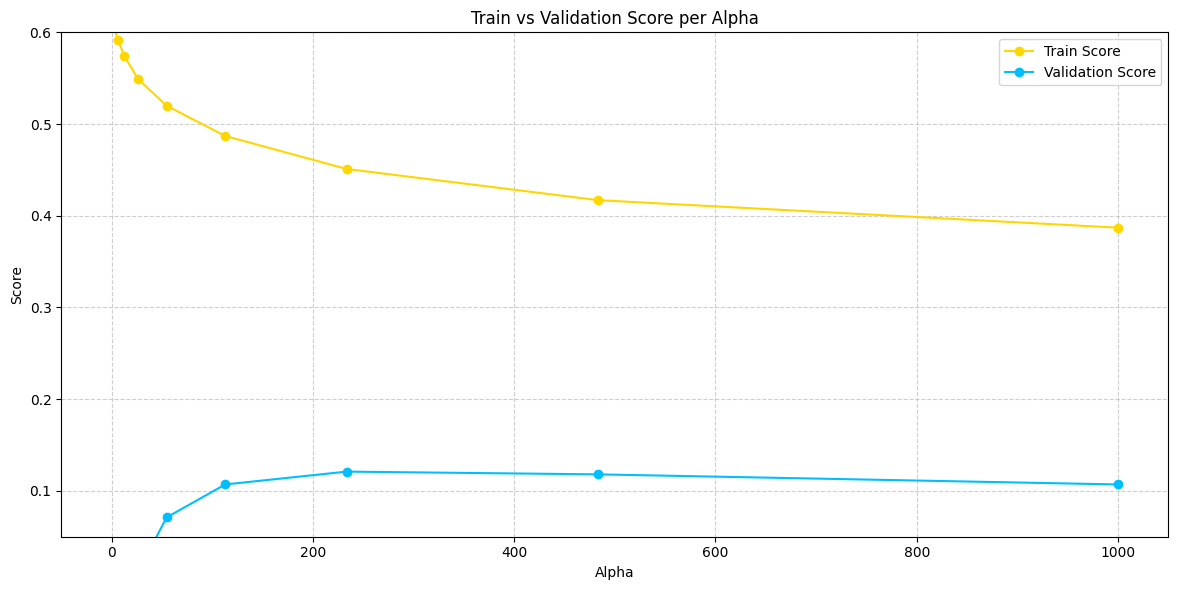

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Dades
alphas = df_results_ridge['alpha']
train_scores = df_results_ridge['train_score_mean']
val_scores = df_results_ridge['val_score_mean']

# Crear el gràfic de línies
plt.figure(figsize=(12, 6))
plt.plot(alphas, train_scores, marker='o', color='gold', label='Train Score')
plt.plot(alphas, val_scores, marker='o', color='deepskyblue', label='Validation Score')

# Etiquetes i títol
plt.xlabel('Alpha')
plt.ylabel('Score')
plt.title('Train vs Validation Score per Alpha')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.ylim(0.05, 0.6)

plt.show()


Random Forest

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

talls = np.concatenate([np.arange(1, 101, 5)])

results_rf = []
c = 0

# Prova diferents valors de n_estimators (nombre d’arbres)
for n_estimators in talls:
    m = []
    n = []
    c += 1
    for r in range(1, 41):
        print(f"{round((c-1+(r-1)/40)*100/len(talls), 5)}%", end='\r', flush=True)
        train_X, test_X, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=r)
        rf_reg = RandomForestRegressor(n_estimators=n_estimators, random_state=42, n_jobs=-1)
        rf_reg.fit(train_X, train_y)
        m.append(rf_reg.score(train_X, train_y))
        n.append(rf_reg.score(test_X, test_y))
    results_rf.append([n_estimators, round(np.mean(m), 3), round(np.mean(n), 3)])

df_results_rf = pd.DataFrame(results_rf, columns=['n_estimators', 'train_score_mean', 'val_score_mean'])
print(df_results_rf.loc[df_results_rf['val_score_mean'].idxmax()])

# Desa i recarrega si cal
df_results_rf.to_pickle(path="data/rf_NV.pkl")

n_estimators        71.000
train_score_mean     0.912
val_score_mean      -0.027
Name: 14, dtype: float64


In [22]:
df_results_rf = pd.read_pickle("data/rf_NV.pkl")

# Entrena el model final amb el millor n_estimators
best_n = int(df_results_rf.loc[df_results_rf['val_score_mean'].idxmax(), 'n_estimators'])
rf_reg = RandomForestRegressor(n_estimators=best_n, random_state=42, n_jobs=-1)
rf_reg.fit(x, y)
y_pred = rf_reg.predict(x)
mse = mean_squared_error(y, y_pred)
print("R² (score):", rf_reg.score(x, y))
print("MSE:", mse)


R² (score): 0.9148549302964228
MSE: 50.279112966427


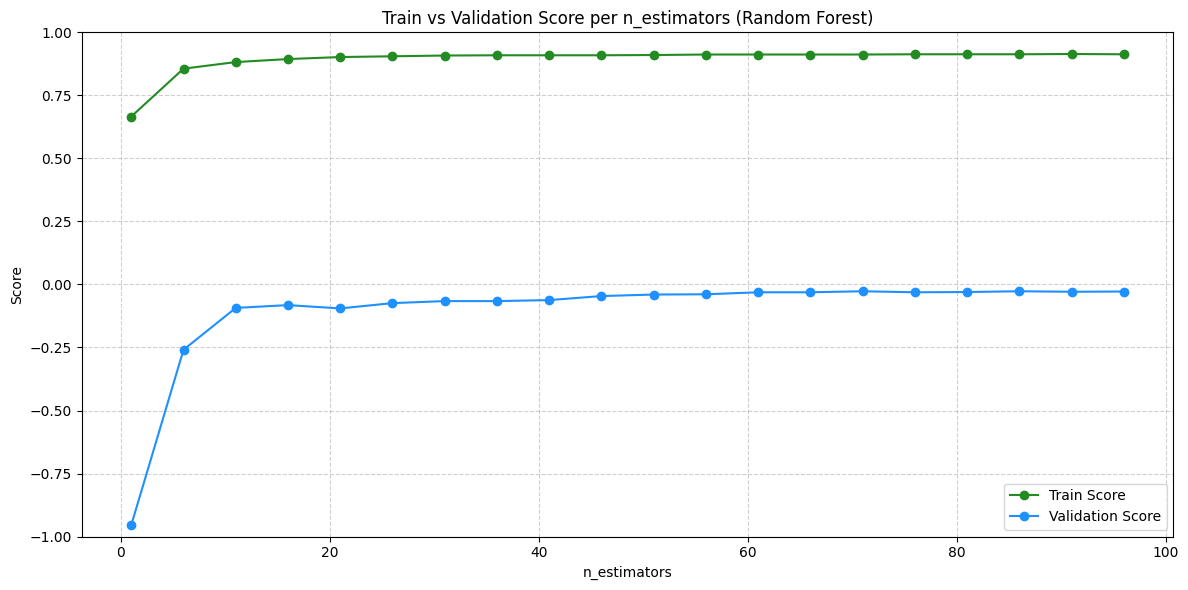

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Dades del Random Forest
n_estimators = df_results_rf['n_estimators']
train_scores_rf = df_results_rf['train_score_mean']
val_scores_rf = df_results_rf['val_score_mean']

# Crear el gràfic de línies
plt.figure(figsize=(12, 6))
plt.plot(n_estimators, train_scores_rf, marker='o', color='forestgreen', label='Train Score')
plt.plot(n_estimators, val_scores_rf, marker='o', color='dodgerblue', label='Validation Score')

# Etiquetes i títol
plt.xlabel('n_estimators')
plt.ylabel('Score')
plt.title('Train vs Validation Score per n_estimators (Random Forest)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.ylim(-1, 1) 

plt.show()


Terrorífic

XGBoost

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

results = []
c = 0
for i in np.arange(1, 30, 1):  # Pot ajustar-se segons dades
    m = []
    n = []
    for r in range(1, 41):  # Repeticions per fer mitjana
        print(f"{round(100 * (c+(r-1)/40)/30, 3)}%", end='\r', flush=True)
        train_X, test_X, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=r)
        model = XGBRegressor(n_estimators=int(i), max_depth=6, learning_rate=0.1, verbosity=0)
        model.fit(train_X, train_y)
        m.append(model.score(train_X, train_y))
        n.append(model.score(test_X, test_y))
    results.append([int(i), round(np.mean(m), 3), round(np.mean(n), 3)])
    c += 1

df_results_xgb = pd.DataFrame(results, columns=['n_estimators', 'train_score_mean', 'val_score_mean'])
print(df_results_xgb.loc[df_results_xgb['val_score_mean'].idxmax()])
df_results_xgb.to_pickle("data/xgb_NV.pkl")


In [ ]:
df_results_xgb = pd.read_pickle("data/xgb_NV.pkl")

best_n = int(df_results_xgb.loc[df_results_xgb['val_score_mean'].idxmax(), 'n_estimators'])
model = XGBRegressor(n_estimators=best_n)
model.fit(x, y)
y_pred = model.predict(x)
mse = mean_squared_error(y, y_pred)
print("R² (score):", model.score(x, y))
print("MSE:", mse)

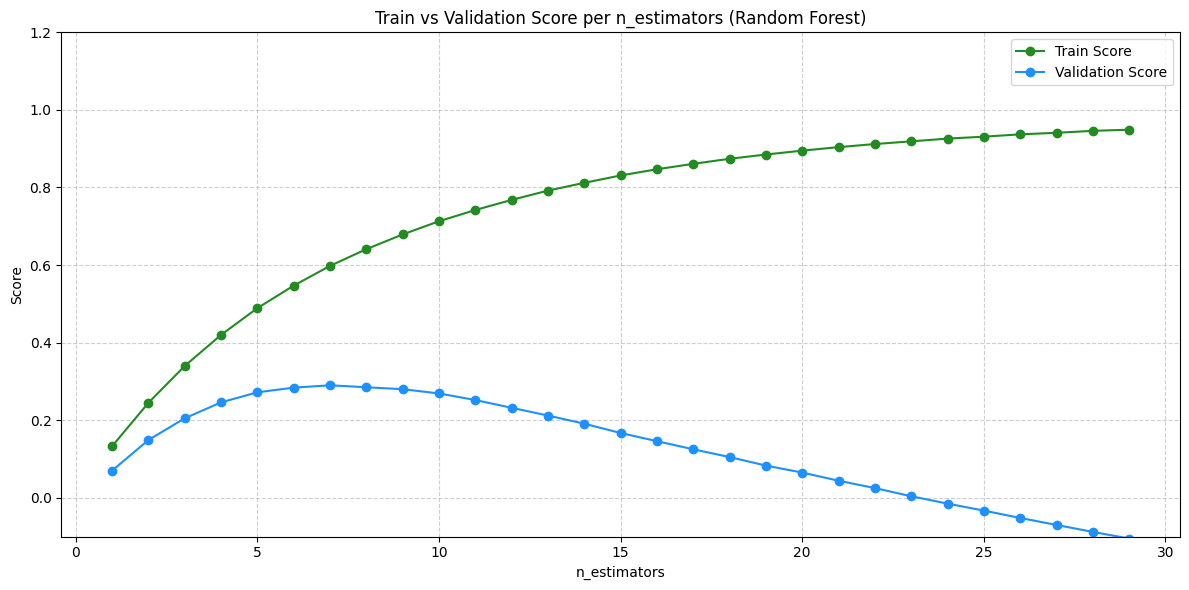

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Dades del Random Forest
n_estimators = df_results_xgb['n_estimators']
train_scores_rf = df_results_xgb['train_score_mean']
val_scores_rf = df_results_xgb['val_score_mean']

# Crear el gràfic de línies
plt.figure(figsize=(12, 6))
plt.plot(n_estimators, train_scores_rf, marker='o', color='forestgreen', label='Train Score')
plt.plot(n_estimators, val_scores_rf, marker='o', color='dodgerblue', label='Validation Score')

# Etiquetes i títol
plt.xlabel('n_estimators')
plt.ylabel('Score')
plt.title('Train vs Validation Score per n_estimators (Random Forest)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.ylim(-0.1, 1.2)

plt.show()


In [27]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

talls = np.arange(1, 30, 1)
results = []
c = 0

for i in talls:
    train_scores = []
    test_scores = []
    test_mse = []
    
    for r in range(1, 41):
        print(f"{round(100 * (c+(r-1)/40)/len(talls), 3)}%", end='\r', flush=True)
        train_X, test_X, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=r)
        model = XGBRegressor(n_estimators=int(i), max_depth=6, learning_rate=0.1, verbosity=0)
        model.fit(train_X, train_y)
        train_scores.append(model.score(train_X, train_y))
        test_scores.append(model.score(test_X, test_y))
        y_pred = model.predict(test_X)
        test_mse.append(mean_squared_error(test_y, y_pred))
    results.append([int(i), round(np.mean(train_scores), 3), round(np.mean(test_scores), 3), round(np.mean(test_mse), 3)])
    c += 1

df_results_xgb = pd.DataFrame(results, columns=['n_estimators', 'train_score_mean', 'val_score_mean', 'val_mse_mean'])
print(df_results_xgb.loc[df_results_xgb['val_score_mean'].idxmax()])
df_results_xgb.to_pickle("data/xgb_NV.pkl")

n_estimators          7.000
train_score_mean      0.598
val_score_mean        0.290
val_mse_mean        449.353
Name: 6, dtype: float64


In [28]:
df_results_xgb = pd.read_pickle("data/xgb_NV.pkl")

best_n = int(df_results_xgb.loc[df_results_xgb['val_score_mean'].idxmax(), 'n_estimators'])
model = XGBRegressor(n_estimators=best_n)
model.fit(x, y)
y_pred = model.predict(x)
mse = mean_squared_error(y, y_pred)
print("R² (score):", model.score(x, y))
print("MSE:", mse)

R² (score): 0.9104785896972513
MSE: 52.86339088329697


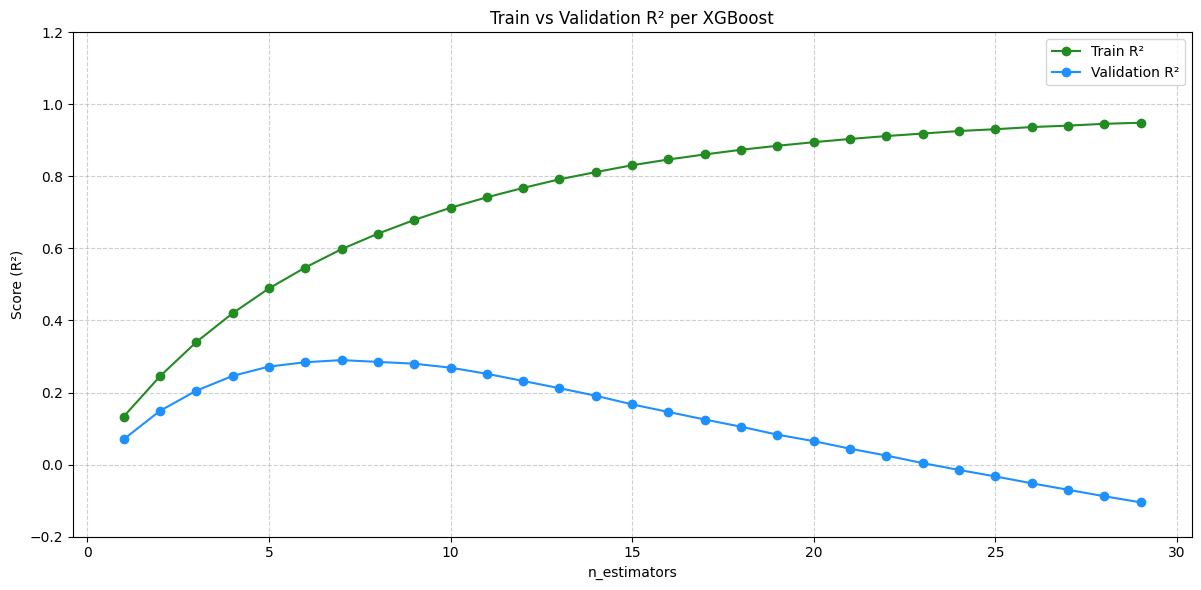

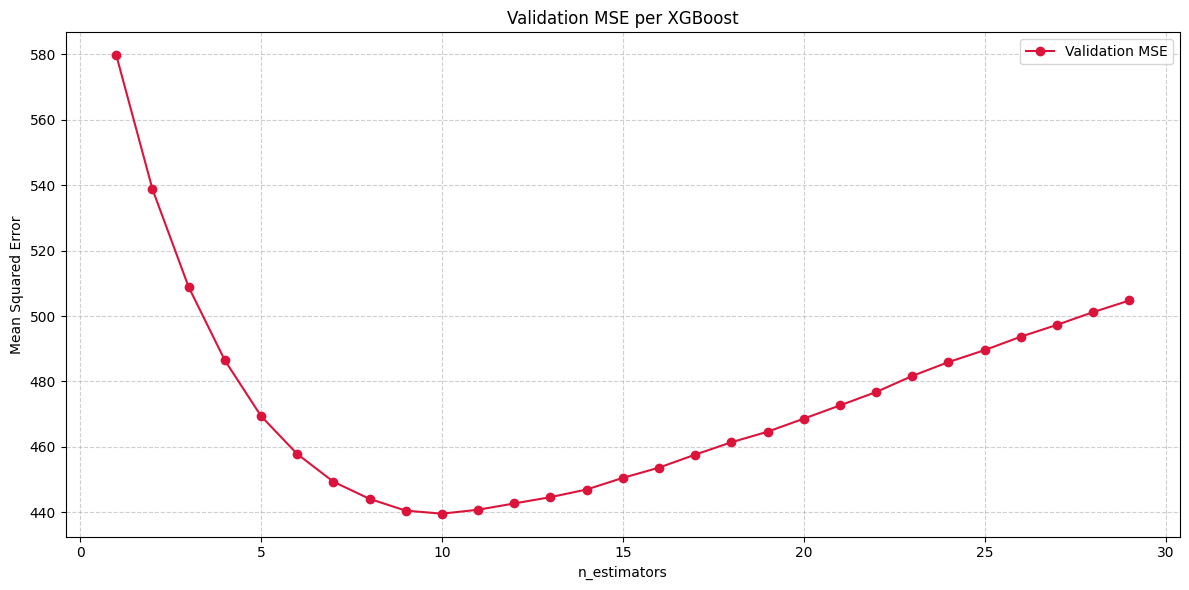

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Dades del XGBoost
n_estimators = df_results_xgb['n_estimators']
train_scores = df_results_xgb['train_score_mean']
val_scores = df_results_xgb['val_score_mean']
val_mse = df_results_xgb['val_mse_mean']

# Gràfic 1: R² Train vs Validation
plt.figure(figsize=(12, 6))
plt.plot(n_estimators, train_scores, marker='o', color='forestgreen', label='Train R²')
plt.plot(n_estimators, val_scores, marker='o', color='dodgerblue', label='Validation R²')
plt.xlabel('n_estimators')
plt.ylabel('Score (R²)')
plt.title('Train vs Validation R² per XGBoost')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.ylim(-0.2, 1.2)
plt.show()

# Gràfic 2: MSE en test
plt.figure(figsize=(12, 6))
plt.plot(n_estimators, val_mse, marker='o', color='crimson', label='Validation MSE')
plt.xlabel('n_estimators')
plt.ylabel('Mean Squared Error')
plt.title('Validation MSE per XGBoost')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Molt bé

SVR

In [30]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

results = []
c = 0
for i in np.linspace(0.0000001, 0.0005, num=40):  # pots ajustar el num si vols més resolució
    train_scores = []
    val_scores = []
    
    for r in range(1, 41):  # pots fer més o menys iteracions
        print(f"{round((c+(r-1)/40)/40*100, 2)}%", end='\r', flush=True)
        train_X, test_X, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=r)
        
        svr_model = SVR(C=i, kernel='linear', epsilon=0.1, max_iter=1000)
        svr_model.fit(train_X, train_y)
        
        train_scores.append(svr_model.score(train_X, train_y))
        val_scores.append(svr_model.score(test_X, test_y))
    c += 1
    results.append([round(i, 4), np.mean(train_scores), np.mean(val_scores)])

# Guardem els resultats
df_results_svr = pd.DataFrame(results, columns=['C', 'train_score_mean', 'val_score_mean'])
print(df_results_svr.loc[df_results_svr['val_score_mean'].idxmax()])
df_results_svr.to_pickle("data/svr_NV.pkl")


C                   0.000200
train_score_mean    0.223280
val_score_mean      0.165772
Name: 15, dtype: float64


In [31]:
df_results_svr = pd.read_pickle("data/svr_NV.pkl")
best_C = df_results_svr.loc[df_results_svr['val_score_mean'].idxmax(), 'C']
final_svr = SVR(C=best_C, kernel='linear', epsilon=0.1, max_iter=1000)
final_svr.fit(x, y)
y_pred = final_svr.predict(x)
mse = mean_squared_error(y, y_pred)
print("R² (score):", final_svr.score(x, y))
print("MSE:", mse)


R² (score): 0.21369868824837646
MSE: 464.3196912850571


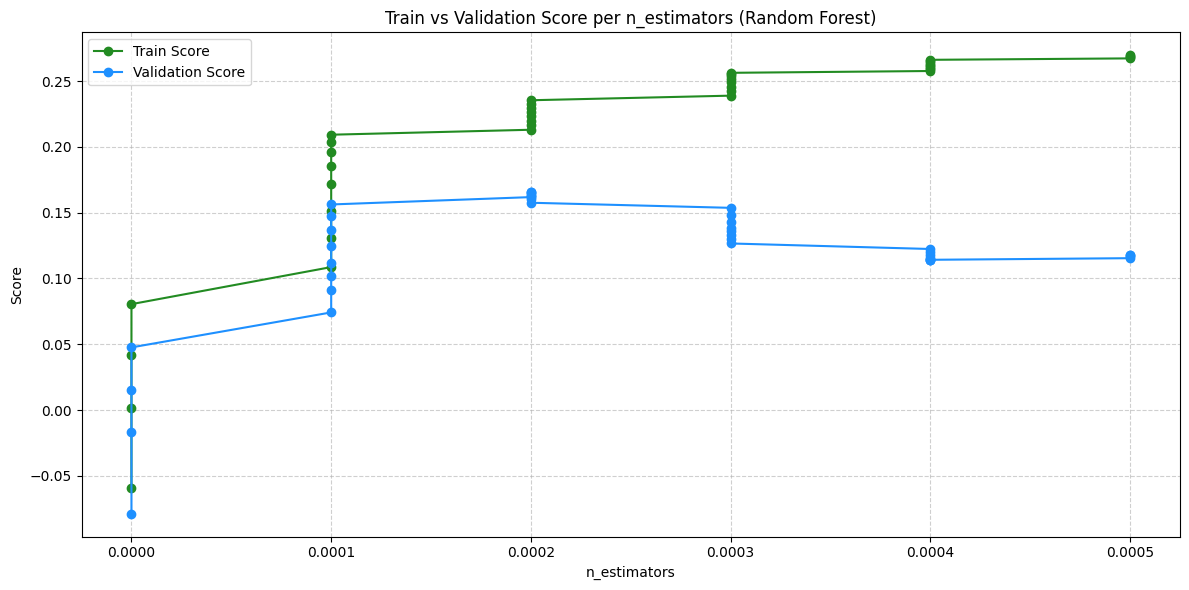

In [32]:
import matplotlib.pyplot as plt
import numpy as np

n_estimators = df_results_svr['C']
train_scores_rf = df_results_svr['train_score_mean']
val_scores_rf = df_results_svr['val_score_mean']

# Crear el gràfic de línies
plt.figure(figsize=(12, 6))
plt.plot(n_estimators, train_scores_rf, marker='o', color='forestgreen', label='Train Score')
plt.plot(n_estimators, val_scores_rf, marker='o', color='dodgerblue', label='Validation Score')

# Etiquetes i títol
plt.xlabel('n_estimators')
plt.ylabel('Score')
plt.title('Train vs Validation Score per n_estimators (Random Forest)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
#plt.ylim(-0.3, 0.5)

plt.show()


Terrorista